In [1]:
! pip install gdown > /dev/null

## For Loop

In [2]:
import gdown
import re
reg = re.compile(r'(\d+) (\d+)')
#https://drive.google.com/file/d/1YVvi9hJgkNbxSd7vvJGi_4v4pfgvFvtB/view?usp=drive_link
gdown.download(id='1YVvi9hJgkNbxSd7vvJGi_4v4pfgvFvtB', output='forloop.out')
with open('forloop.out') as f:
  lines = f.read()

stats = reg.findall(lines)

Downloading...
From (original): https://drive.google.com/uc?id=1YVvi9hJgkNbxSd7vvJGi_4v4pfgvFvtB
From (redirected): https://drive.google.com/uc?id=1YVvi9hJgkNbxSd7vvJGi_4v4pfgvFvtB&confirm=t&uuid=1061f337-c120-4db1-8149-99ebc44e3882
To: /content/forloop.out
100%|██████████| 57.7k/57.7k [00:00<00:00, 36.7MB/s]


In [3]:
! head -n 5 forloop.out

1 9766
2500000 2509765
3750000 3759765
625000 634765
1250000 1259765


In [4]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

for i, (a, b) in enumerate(stats):
  stats[i] = (int(a), int(b))

df = pd.DataFrame(stats, columns=['start_idx', 'end_idx'])
df['idx_range'] = df.end_idx - df.start_idx
df['job_id'] = list(range(len(df.index)))
sns.set_theme(style="ticks")
df

,start_idx,end_idx,idx_range,job_id
0,1,9766,9765,0
1,2500000,2509765,9765,1
2,3750000,3759765,9765,2
3,625000,634765,9765,3
4,1250000,1259765,9765,4
...,...,...,...,...
3619,3622385,3622386,1,3619
3620,3622337,3622338,1,3620
3621,3622338,3622339,1,3621
3622,3622352,3622353,1,3622


<Axes: xlabel='job_id', ylabel='idx_range'>

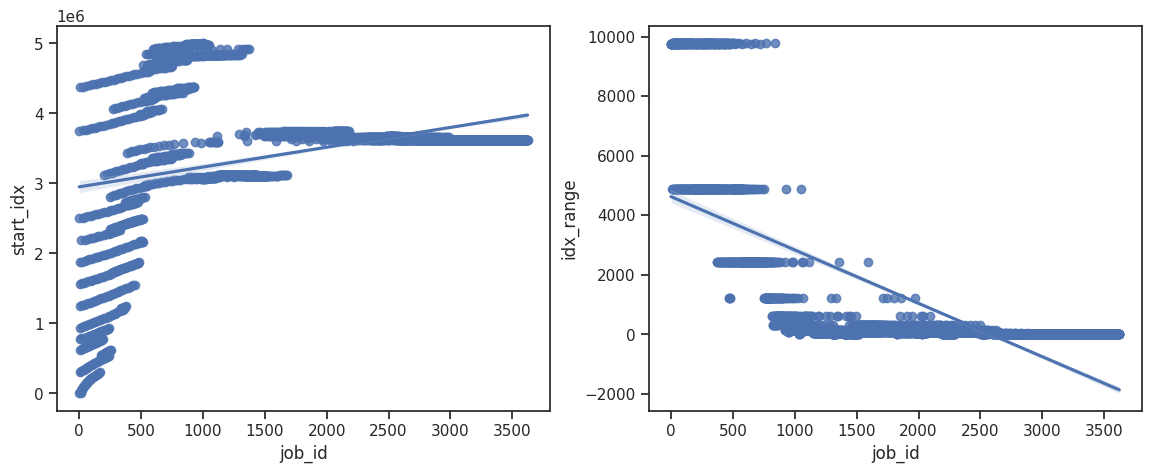

In [5]:
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
sns.regplot(data=df, x='job_id', y='start_idx')
plt.subplot(1, 2, 2)
sns.regplot(data=df, x='job_id', y='idx_range')

The limitation is that the data was ordered by an atomic increment and get.

It does seem, looking at the left plot, that tbb tries to process the data from begining to end, perhaps with some interleaving to avoid cache conflicts or something of the sort.

The right plot shows that tbb sends smaller and smaller ranges as we progress. This is supposedly some kind of load management that adapts on the fly, halfing the range every time. The last jobs had a range of 1 which could be optimised out by setting the grain size in parallel for.

## Tribonacci

The tribonacci was implemented naively
```cpp
long seq_trib(long n)
{
    if (n < 2)
    {
        return n > 0 ? n : 0;
    }
    else
    {
        long x, y, z;
        x = seq_trib(n - 1);
        y = seq_trib(n - 2);
        z = seq_trib(n - 3);
        return x + y + z;
    }
}

long par_trib(long n)
{
    if (n < 2)
    {
        return n > 0 ? n : 0;
    }
    else
    {
        long x, y, z;
        tbb::task_group g;
        g.run([&]
              { x = par_trib(n - 1); }); // spawn a task
        g.run([&]
              { y = par_trib(n - 2); }); // spawn another task
        g.run([&]
              { z = par_trib(n - 3); }); // spawn another task
        g.wait();                        // wait for all tasks to complete
        return x + y + z;
    }
}
```
And as we can expect was very slow
```
trib 29249425
seq time 0.221714[s]
p_trib 29249425
par time 15.2521[s]
```

## N Queens
I send a task only in the first 3 columns of the board. For large boards most of the queens positions are valid and this gives around 1000 tasks total, with 1000 unique baords to store. This seemed like a sensible memory consumption and tasks total for my laptop with 6 cores, 12 threads.

In [7]:
#https://drive.google.com/file/d/1d0dbsVcMm72FjFq_rEOFGx6VQHy7JurN/view?usp=drive_link
gdown.download(id='1d0dbsVcMm72FjFq_rEOFGx6VQHy7JurN', output='nqueens.out')

Downloading...
From (original): https://drive.google.com/uc?id=1d0dbsVcMm72FjFq_rEOFGx6VQHy7JurN
From (redirected): https://drive.google.com/uc?id=1d0dbsVcMm72FjFq_rEOFGx6VQHy7JurN&confirm=t&uuid=2d75b812-3c43-4a8b-8735-ca3d3b7261b2
To: /content/nqueens.out
100%|██████████| 743/743 [00:00<00:00, 1.86MB/s]


'nqueens.out'

In [19]:
df = pd.read_csv('nqueens.out').astype({'store_sol':bool})
temp_dict = {}
for (_, r) in df.iterrows():
  # solutions storage?, board size, parallel?
  temp_dict[(r[0], r[1], True)] = r[2]
  temp_dict[(r[0], r[1], False)] = r[3]
columns = ['board_size', 'speedup_count', 'speedup_store', 'abs_degradation', 'relative_degradation']
data = []
for b_size in range(3, 15):
  speedup_count = temp_dict[(False, b_size, False)] / temp_dict[(False, b_size, True)]
  speedup_store = temp_dict[(True, b_size, False)] / temp_dict[(True, b_size, True)]
  abs_deg = temp_dict[(False, b_size, True)] / temp_dict[(True, b_size, True)]
  rel_deg = speedup_store / speedup_count
  data.append((b_size, speedup_count, speedup_store, abs_deg, rel_deg))
df = pd.DataFrame(data, columns=columns)
df

,board_size,speedup_count,speedup_store,abs_degradation,relative_degradation
0,3,0.001356,0.002371,1.466398,1.749123
1,4,0.003906,0.013142,2.335425,3.364297
2,5,0.019254,0.047334,1.590223,2.458426
3,6,0.108277,0.118037,2.513622,1.090141
4,7,0.284017,0.337180,1.081593,1.187184
5,8,0.889462,2.005154,1.822372,2.254345
6,9,3.218713,4.232124,1.257779,1.314850
7,10,7.203235,7.060682,1.040138,0.980210
8,11,8.304193,8.345548,0.995662,1.004980
9,12,7.741575,7.100348,0.899533,0.917171


The speedup when just counting the number of solutions seems sensible.

<Axes: xlabel='board_size', ylabel='speedup_count'>

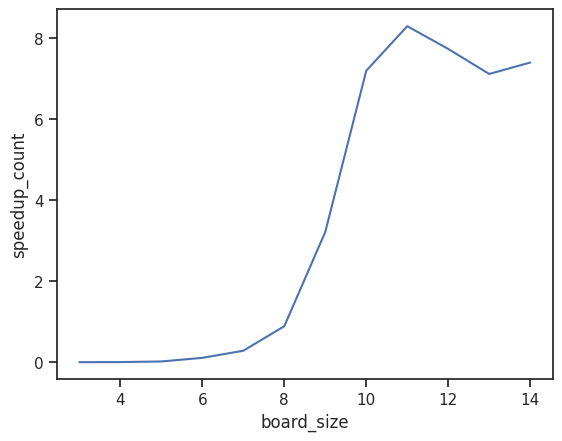

In [20]:
sns.lineplot(x='board_size', y='speedup_count', data=df)

It's similar for storing the actual solutions.

<Axes: xlabel='board_size', ylabel='speedup_store'>

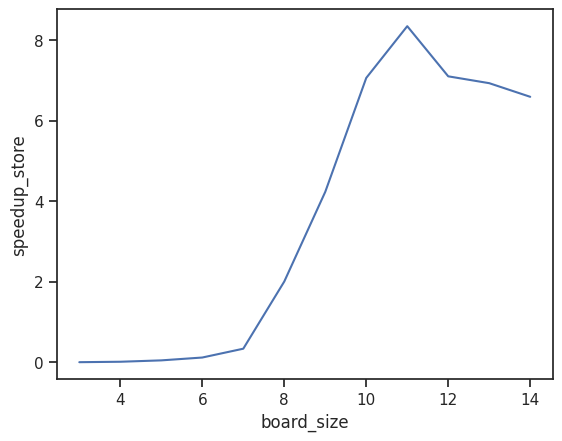

In [21]:
sns.lineplot(x='board_size', y='speedup_store', data=df)

`atomic_long` seems to be very slow as for small board sizes its slower than actaully storing the solution in a parallel implementation. Below we see the absolute speedup i.e. $\frac{\text{time to execute in parallel with storing solutions}}{\text{time to execute in parallel without storing solutions}}$


<Axes: xlabel='board_size', ylabel='abs_degradation'>

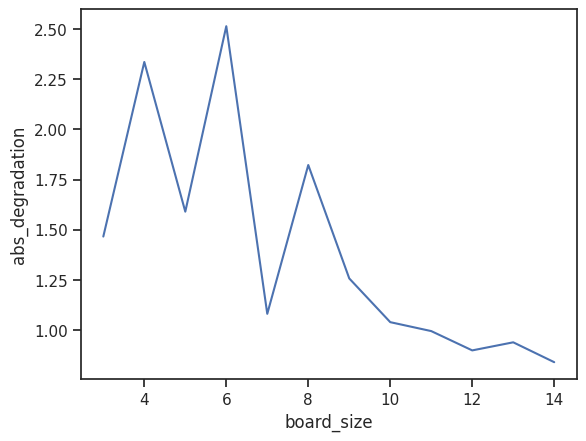

In [22]:
sns.lineplot(x='board_size', y='abs_degradation', data=df)

We can also look at relative speedup i.e. $\frac{\text{speedup with storing solutions}}{\text{speedup without storing solutions}}$. It seems like storing the solutions provides at least as much speedup as an implementation with atomics. This is already with relaxed memory ordering for the atomic incrementation.

<Axes: xlabel='board_size', ylabel='relative_degradation'>

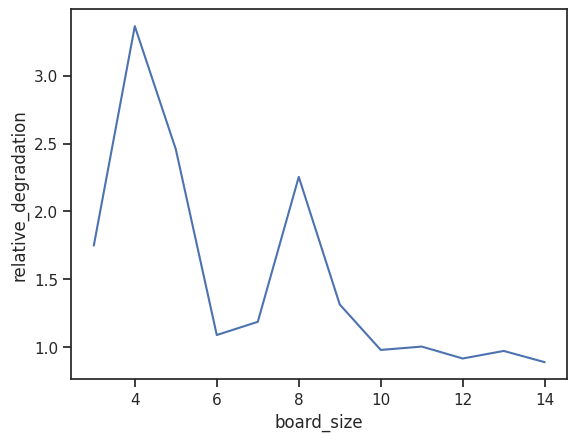

In [24]:
sns.lineplot(x='board_size', y='relative_degradation', data=df)